In [2]:
!pip uninstall tslearn


Found existing installation: tslearn 0.6.3
Uninstalling tslearn-0.6.3:
  Would remove:
    /home/danube/.local/lib/python3.10/site-packages/tslearn-0.6.3.dist-info/*
    /home/danube/.local/lib/python3.10/site-packages/tslearn/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [4]:
!pip install tslearn
!pip install pesq
!pip install pystoi


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [262]:
! pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 35.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 32.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 34.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 33.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 36.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 36.1 MB/s

In [864]:
import IPython
import os
from scipy.io import wavfile
from tslearn.metrics import dtw, dtw_path
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pesq import pesq
from pystoi.stoi import stoi
from torch.utils.data import Dataset
import os
from tqdm import tqdm
import pickle
from torch.utils.data import random_split
import torchaudio.transforms as T
import torch.nn.functional as F
from pesq import pesq
from pystoi.stoi import stoi

In [2]:
print("GPU is", "available" if torch.cuda.is_available() else "not available")

GPU is available


# MVA 2024 : Cours Deep et signal, mini-projet

Consignes :

Pour chaque sujet vous êtes invités à prendre des initiatives notamment pour
- analyser les données (statistiques haut niveau, visualisation, évaluation des difficultés)
- partir du cours ou d'un article lié au sujet traité que vous aurez identifié dans une (rapide) étude bibliographique
- définir une ou plusieurs métriques d'évaluation
- définir et implémenter une méthode baseline dont les performances vous serviront de référence
- implémenter au moins une et idéalement deux méthodes traitant le problème considéré. Au moins une des deux méthodes est une approche par apprentissage profond. La seconde peut être une approche de traitement du signal classique, une autre architecture de réseau, la même architecture avec une stratégie d'augmentation de données ou d’ingénierie des données...
- comparer les approches quantitativement et analyser qualitativement vos résultats, les cas de succès et les cas d'échecs.

Si vous n'avez pas abouti à des résultats probants sur cette durée vous êtes invités à analyser de façon critique vos résultats et émettre des hypothèse sur ce qui n'a pas fonctionné (type d'approche, architecture, qualité des données...).
Une bonne analyse de vos résultats et une méthodologie rigoureuses seront largement valorisées dans l'évaluation, vos initiatives aussi.

Pour l'évaluation je serai très attentif à la méthodologie que vous avez suivie, aux initiatives que vous aurez prises et à l'analyse critique des données, du sujet, des approches, de vos résultats..

Pour chaque sujet, vous êtes libres d'explorer les pistes qui vous intéressent (tant qu'elles sont raisonnables).
Si vous avez des idées originales n'hésitez pas à être créatifs !


### Complétion de paquets perdus
Lors d'une communication sur IP les échantillons sont envoyés sous forme de paquets. Un paquet a une certaine probabilité d'être perdu ce qui produit un "trou" dans le signal reçu.
L'objectif de ce projet est de combler les trous dans un signal de voix.

Le dataset de train se compose de  :
- Un dossier contenant des fichiers d'enregistrements de voix à 8kHz  (audio/voice_origin/train) ; ce sont les données objectifs
- Un dossier contenant les fichiers correspondants avec certains paquets qui ont été perdu (audio/packet_loss/train) ; ce sont les données d'entrée à traiter

La correspondance entre les deux dossiers pour reconstituer les paires (donnée d'entrée, vérité terrain) se fait par le nom de fichier.
Les données de test sont structurées de la même façon.

Vous pouvez au choix travailler sur spectrogramme ou directement sur la forme d'onde en vous inspirant par exemple des références données pour la séparation de sources (UNet, WavUnet)

- Sur le spectrogramme par exemple en vous des approches par masquage présentés dans le cours  et en estimant les masques avec un réseau Seq2Seq de votre choix ou un UNet (cf A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017 )
- directement sur la forme d'onde  :
   - cf D. Stoller  et Al., WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION, ISMIR 2018
   - les apporches TAS NEt : Y. Luo et Al., TaSNet: Time-Domain Audio Separation Network for Real-Time, Single-Channel Speech Separation, ICASSP 2018 ou Y. Luo et Al.,  Conv-tasnet: surpassing ideal time–frequency magnitude masking for speech separation. IEEE/ACM Transactions on Audio, Speech, and Language Processing, 2019.)

Pour ce sujet vous implémenterez nécessairement une approche classique  par exemple en utilisant des interpolations et une méthode à base de réseaux de neurones profonds.

Libre à vous de choisir la fonction de perte utilisée dans l’entraînement.
Pour l'évaluation des performances sur l'ensemble de test, outre la fonction de perte vous vous intéresserez au PESQ et au STOI des voix estimées.

# Complétion de Paquets Perdus

In [272]:
# Pour notebook en local
chemin = "."

In [273]:
# Charger le drive
from google.colab import drive
drive.mount('/content/drive')
# Chemin du répertoire de mon drive contenant les données
chemin = '/content/drive/MyDrive/Colab Notebooks/S1 I&I/mini-projet/'

ModuleNotFoundError: No module named 'google.colab'

In [4]:
# Fonction pour charger les données
def charger_donnees(dossier):
    list_to_fill = []
    # Parcourir les fichiers .wav dans le dossier
    for fichier in os.listdir(dossier):
        if fichier.endswith(".wav"):
            chemin_complet = os.path.join(dossier, fichier)
            samplerate, data = wavfile.read(chemin_complet)
            list_to_fill.append({
                "nom": fichier,
                "samplerate": samplerate,
                "data": data})
    return sorted(list_to_fill, key=lambda d: d["nom"])

In [186]:
dossier_packetloss_train, dossier_voiceorigin_train = chemin + '/packet_loss/train', chemin + '/voice_origin/train'
dossier_packetloss_test, dossier_voiceorigin_test = chemin + '/packet_loss/test', chemin + '/voice_origin/test'

X_train, Y_train = charger_donnees(dossier_packetloss_train), charger_donnees(dossier_voiceorigin_train)
X_test, Y_test = charger_donnees(dossier_packetloss_test), charger_donnees(dossier_voiceorigin_test)

print(f"Ensemble d'entraînement : {len(X_train)} fichiers avec pertes de paquets et {len(Y_train)} fichiers de voix originaux.")
print(f"Ensemble de test : {len(X_test)} fichiers avec pertes de paquets et {len(Y_test)} fichiers de voix originaux.")

Ensemble d'entraînement : 2118 fichiers avec pertes de paquets et 2118 fichiers de voix originaux.
Ensemble de test : 782 fichiers avec pertes de paquets et 782 fichiers de voix originaux.


In [188]:
# On vérifie qu'il y a bien une unique sample rate (à enlever ?)
samplerates = []
for dic in X_train : samplerates.append(dic['samplerate'])
for dic in Y_train : samplerates.append(dic['samplerate'])
for dic in X_test : samplerates.append(dic['samplerate'])
for dic in Y_test : samplerates.append(dic['samplerate'])
print("La liste des differentes samplerates du dataset de train et test est :", np.unique(np.array(samplerates)))
samplerate = samplerates[0]

La liste des differentes samplerates du dataset de train et test est : [8000]


In [110]:
idx = 43

In [111]:
IPython.display.Audio(X_train[idx]['data'], rate=samplerate) #with packet loss

In [112]:

IPython.display.Audio(Y_train[idx]['data'], rate=samplerate) #without (original sound)

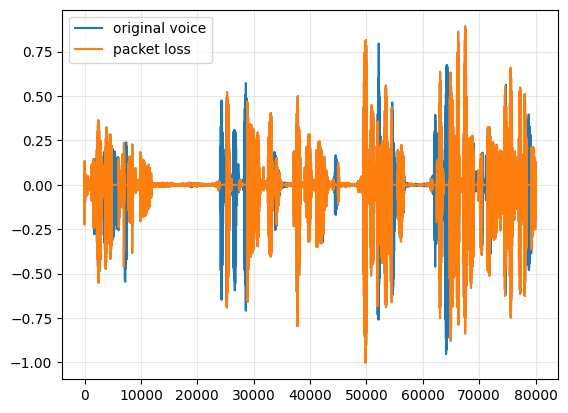

In [265]:
idx = 43
plt.figure()
plt.plot(Y_train[idx]['data'], label ="original voice")
plt.plot(X_train[idx]['data'], label = "packet loss")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

**On remarque qu'il faut renormaliser les signaux**

In [189]:
# Fonction pour normaliser un signal
def normaliser(signal):
    max_val = np.max(np.abs(signal))
    return signal / max_val

for dic in X_train : dic['data'] = normaliser(dic['data'])
for dic in Y_train : dic['data'] = normaliser(dic['data'])
for dic in X_test : dic['data'] = normaliser(dic['data'])
for dic in Y_test : dic['data'] = normaliser(dic['data'])

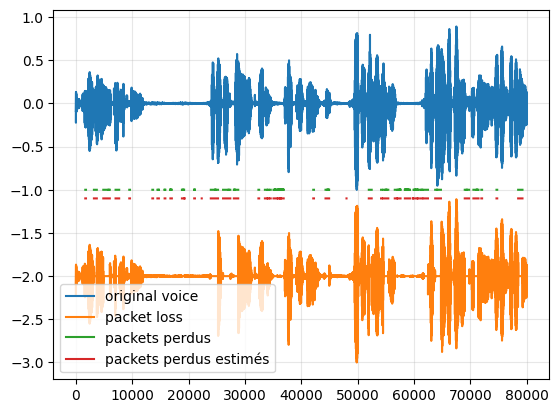

In [190]:
idx = 43

# Signal analysis
signal_og = Y_train[idx]['data']
signal_loss = X_train[idx]['data']
indices = []
for i in range(len(signal_og)):
  if abs(signal_og[i] - signal_loss[i]) > 1e-6:
        indices.append(i)
bursts = np.nan * np.ones(len(signal_og))
for i in indices:
  bursts[i] = -1

bursts_estimes = np.nan * np.ones(len(signal_loss))
indices_paquets_perdus = np.where(signal_loss == 0.0)
bursts_estimes[indices_paquets_perdus] = -1.1

# Plot
plt.figure()
plt.plot(signal_og, label ="original voice")
plt.plot(signal_loss-2, label = "packet loss")
plt.plot(bursts, label = "packets perdus")
plt.plot(bursts_estimes, label = "packets perdus estimés")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [266]:
def true_blocks_dictionnary(lst):
  """
  retourne pour une liste de True/False
  (True : il y a un paquet perdu à cet indice dans le signal sonore)
  le dictionnaire retourné a pour clés : l'indice de début du paquet perdu
  et pour valeur : la taille du paquet perdu
  """
  result = {}
  start = None  # Indice de début d'un bloc de True

  for i, val in enumerate(lst):
      if val:  # Si c'est un True
          if start is None:  # Début d'un nouveau bloc
              start = i
      else:  # Si c'est un False
          if start is not None:  # Fin d'un bloc de True
              result[start] = i - start  # Longueur du bloc
              start = None

  # Ajouter le dernier bloc s'il se termine par un True
  if start is not None:
      result[start] = len(lst) - start

  return result

# Exemple d'utilisation
lst = [True, True, False, True, True, True, False, False]
result = true_blocks_dictionnary(lst)
print(result)

{0: 2, 3: 3}


In [267]:
def baseline_interpolation(signal_loss):
  signal_reconstruction = signal_loss.copy()

  paquets_perdus_estimes = False * np.ones(len(signal_loss))
  indices_paquets_perdus = np.where(signal_loss == 0.0)
  paquets_perdus_estimes[indices_paquets_perdus] = True

  paquets_perdus_dictionnary = true_blocks_dictionnary(paquets_perdus_estimes)
  for debut, duree in paquets_perdus_dictionnary.items():
    valeur_debut, valeur_fin = signal_loss[debut-1], signal_loss[debut+duree]
    signal_reconstruction[debut:debut+duree] = np.linspace(valeur_debut, valeur_fin, duree)

  return signal_reconstruction

In [269]:
signal_reconstruction = baseline_interpolation(signal_loss)

In [270]:
IPython.display.Audio(signal_loss, rate=samplerate)

In [271]:
IPython.display.Audio(signal_og, rate=samplerate)

In [272]:
IPython.display.Audio(signal_reconstruction, rate=samplerate)

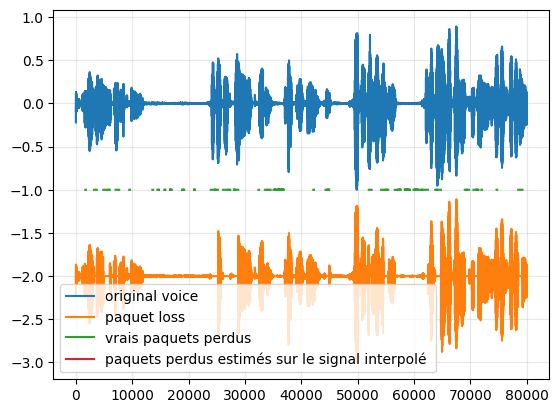

In [273]:
# Estimations des paquets perdus sur le signal reconstruit
bursts_estimes = np.nan * np.ones(len(signal_loss))
indices_paquets_perdus = np.where(signal_reconstruction == 0.0)
bursts_estimes[indices_paquets_perdus] = -1.1

# Plot
plt.figure()
plt.plot(signal_og, label ="original voice")
plt.plot(signal_loss-2, label = "paquet loss")
plt.plot(bursts, label = "vrais paquets perdus")
plt.plot(bursts_estimes, label = "paquets perdus estimés sur le signal interpolé ")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

**Donc il n'y bien plus de paquets perdus estimés**, mais à l'oreille le signal n'est pas amélioré par l'interpolation.

Quantifions la reconstruction avec plusieurs métriques :
- MSE (Mean Square Error)
- PESQ (Perceptual Evaluation of Speech Quality):
  - PESQ $\in \left[1;2\right[$ impossible de comprendre
  - PESQ $\in \left[2;2.4\right[$ effort considérable pour comprendre
  - PESQ $\in \left[2.4;2.8\right[$ effort modéré pour comprendre
  - PESQ $\in \left[2.8;3.3\right[$ attention nécessaire et effort léger
  - PESQ ∈ $\in \left[3.3;3.8\right[$ attention nécessaire
  - PESQ $\in \left[3.8;4.5\right[$ aucun effort requis
- STOI (Short-Time Objective Intelligibility) :
  - STOI $\in \left[0;1\right]$ (1 pour reconstruction parfaite)

In [863]:
def L2_squared(x):
  assert(type(x) == np.ndarray)
  return np.sum(x**2) / len(x)

def MSE(x, x_reconstructed):
  assert(type(x) == type(x_reconstructed) == np.ndarray)
  assert(x.shape == x_reconstructed.shape)
  return L2_squared(x - x_reconstructed)

def SNR(x, x_reconstructed):
  assert(type(x) == type(x_reconstructed) == np.ndarray)
  assert(x.shape == x_reconstructed.shape)
  return 10*np.log10(L2_squared(x)/L2_squared(x-x_reconstructed))

def SISNR(x, x_reconstructed):
  return None

def S_Loss1(x, x_reconstructed):
  return None

def S_Loss2(x, x_reconstructed):
  return None

In [275]:
mse_score_parfait = MSE(signal_og, signal_og)
mse_score_initial = MSE(signal_og, signal_loss)
mse_score_reconstruction = MSE(signal_og, signal_reconstruction)
print("MSE témoin parfait", mse_score_parfait)
print("MSE avant reconstruction :", mse_score_initial)
print("MSE après reconstruction :", mse_score_reconstruction) # Parfois encore pire après reconstruction !!

MSE témoin parfait 0.0
MSE avant reconstruction : 0.003726402572388237
MSE après reconstruction : 0.0066622077762747865


In [276]:
snr_score_parfait = SNR(signal_og, signal_og) #donne +inf : logique => métrique pas top pour ce genre de problèmes de paquet loss
snr_score_initial = SNR(signal_og, signal_loss)
snr_score_reconstruction = SNR(signal_og, signal_reconstruction)
print("SNR témoin parfait", snr_score_parfait)
print("SNR avant reconstruction :", snr_score_initial)
print("SNR après reconstruction :", snr_score_reconstruction)

SNR témoin parfait inf
SNR avant reconstruction : 6.058864898908806
SNR après reconstruction : 3.535580878423845


/tmp/ipykernel_207422/845209022.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return 10*np.log10(L2_squared(x)/L2_squared(x-x_reconstructed))


In [277]:
pesq_score_parfait = pesq(samplerate, signal_og, signal_og, 'nb')  # PESQ en bande étroite (8 kHz)
pesq_score_initial = pesq(samplerate, signal_og, signal_loss, 'nb')
pesq_score_reconstruction = pesq(samplerate, signal_og, signal_reconstruction, 'nb')
print("PESQ témoin parfait", pesq_score_parfait)
print("PESQ avant reconstruction :", pesq_score_initial)
print("PESQ après reconstruction :", pesq_score_reconstruction)

PESQ témoin parfait 4.548638343811035
PESQ avant reconstruction : 1.3512659072875977
PESQ après reconstruction : 1.3644766807556152


In [278]:
stoi_score_parfait = stoi(signal_og, signal_og, samplerate)
stoi_score_initial = stoi(signal_og, signal_loss, samplerate)
stoi_score_reconstruction = stoi(signal_og, signal_reconstruction, samplerate)
print("STOI témoin parfait :", stoi_score_parfait)
print("STOI avant reconstruction :", stoi_score_initial)
print("STOI après reconstruction :", stoi_score_reconstruction)

STOI témoin parfait : 1.0
STOI avant reconstruction : 0.7494499684872334
STOI après reconstruction : 0.7546432644226532


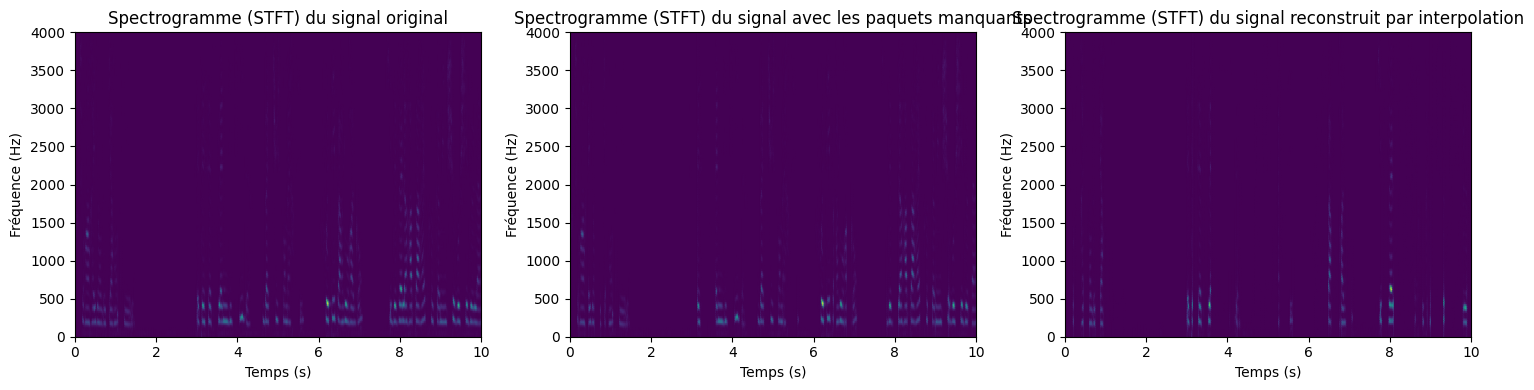

In [280]:
nperseg = 256 ## A changer cf TP1

f_stft_og, t_stft_og, amplitude_stft_og = stft(signal_og, samplerate, nperseg=nperseg)
f_stft_loss, t_stft_loss, amplitude_stft_loss = stft(signal_loss, samplerate, nperseg=nperseg)
f_stft_reconstruction, t_stft_reconstruction, amplitude_stft_reconstruction = stft(signal_reconstruction, samplerate, nperseg=nperseg)

# Tracer le spectrogramme

fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].pcolormesh(t_stft_og, f_stft_og, np.abs(amplitude_stft_og), shading='gouraud', cmap='viridis')
axes[0].set_title("Spectrogramme (STFT) du signal original")
axes[0].set_xlabel("Temps (s)")
axes[0].set_ylabel("Fréquence (Hz)")
#axes[0].colorbar(label="Amplitude")

axes[1].pcolormesh(t_stft_loss, f_stft_loss, np.abs(amplitude_stft_loss), shading='gouraud', cmap='viridis')
axes[1].set_title("Spectrogramme (STFT) du signal avec les paquets manquants")
axes[1].set_xlabel("Temps (s)")
axes[1].set_ylabel("Fréquence (Hz)")
#axes[1].colorbar(label="Amplitude")

axes[2].pcolormesh(t_stft_reconstruction, f_stft_reconstruction, np.abs(amplitude_stft_reconstruction), shading='gouraud', cmap='viridis')
axes[2].set_title("Spectrogramme (STFT) du signal reconstruit par interpolation")
axes[2].set_xlabel("Temps (s)")
axes[2].set_ylabel("Fréquence (Hz)")
#axes[2].colorbar(label="Amplitude")

axes[2].pcolormesh(t_stft_reconstruction, f_stft_reconstruction, np.abs(amplitude_stft_og - amplitude_stft_loss), shading='gouraud', cmap='viridis')
axes[2].set_title("Spectrogramme (STFT) du signal reconstruit par interpolation")
axes[2].set_xlabel("Temps (s)")
axes[2].set_ylabel("Fréquence (Hz)")
plt.tight_layout()
plt.show()

**Faire la baseline sur tout le dataset**

In [45]:
! python3.10 -m pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 27.7 MB/s eta 0:00:00 0:00:01
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [46]:
def ar_interpolation(signal_loss , lag = 5):
    model = AutoReg(signal_loss, lags=lag)
    model_fit = model.fit()
    pred = model_fit.predict()
    return pred
    

# Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
- un **Dataset** qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
- un **Dataloader** qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones



(Qn : d'ailleurs on a pas de datset de validation ... donc pour savoir quand arrêter l'entraienement il va falloir s'y pencher...)

In [5]:

device = "cuda" if torch.cuda.is_available() else "cpu"
class DatasetVoice(Dataset):
    def __init__(self, chemin = ".", type_ = "train", nb_samples = 1000, transform = None):
        types = ["train", "test", "train_small"]
        if type_ not in types:
            return Exception("Please provide a correct type among those : " + str(types)) 
        dicX, dicY = charger_donnees(os.path.join(chemin, "packet_loss", type_ )), charger_donnees(os.path.join(chemin, "voice_origin", type_ ))
        
        split = len(dicX[0]["data"]) // nb_samples
        self.X = torch.zeros(len(dicX) * split, len(dicX[0]["data"]) // split)#.to(device)
        self.y = torch.zeros(len(dicY) * split, len(dicY[0]["data"]) // split)#.to(device)
        step = len(dicX[0]["data"]) // split
        for i in tqdm(range(0, len(dicX))):
            dicX[i]["data"] = dicX[i]["data"] / np.max(np.abs(dicX[i]["data"]))
            dicY[i]["data"] = dicY[i]["data"] / np.max(np.abs(dicY[i]["data"]))
            splitsX = [dicX[i]["data"][j:j+step] for j in range(0, len(dicX[i]["data"]), step)]
            splitsY = [dicY[i]["data"][j:j+step] for j in range(0, len(dicY[i]["data"]), step)]
            if split == 1:
                splits = [dicX[i]["data"]]
            for j in range(len(splitsX)):
                self.X[i * split +  j] = torch.from_numpy(splitsX[j])#.to(device)
                self.y[i * split+ j] = torch.from_numpy(splitsY[j])#.to(device)
        self.X = self.X.to(device)
        self.y = self.y.to(device)
        self.transform = transform.to(device)
    def __getitem__(self, i):
        feature, target = self.X[i], self.y[i]
        if self.transform:
            feature = self.transform(feature)
            target = self.transform(target)
        return feature, target
    def __len__(self):
        return len(self.X)

In [207]:
dataset_train = DatasetVoice(type_ = "train", nb_samples = 100,)
dataset_test = DatasetVoice(type_ = "test", nb_samples = 100)


torch.Size([2118, 80000])
torch.Size([2118, 80000])


100%|█████████████████████████████████████████████████████████████████████████████| 2118/2118 [00:01<00:00, 1820.23it/s]


torch.Size([782, 80000])
torch.Size([782, 80000])


100%|███████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 1863.70it/s]


In [62]:
prop_eval = 0.1
prop_train = 0.9
dataset_eval, dataset_train  = random_split(dataset_train, [prop_eval, prop_train])

In [63]:
print("Taille train : ", len(dataset_train))
print("Taille test : ", len(dataset_test))
print("Taille eval : ", len(dataset_eval))

Taille train :  1524960
Taille test :  625600
Taille eval :  169440


# Baseline avec un réseau de neurones

La baseline consiste en un simple modèle RNN (GRU). 
Cependant, comme les signaux sont beaucoup trop longs, nous allons les découper par tranches de 100 échantillons pour avoir un modèle RNN de taille raisonnable.

In [151]:


class BaselineNet(nn.Module):
    def __init__(self, input_size = 100, output_size = 100):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size).to(device)
        self.input_size = input_size
        self.output_size = output_size
    def forward(self, batch):
        output = self.fc(batch,)
        output = self.sigmoid(output,)
        return output

In [152]:
net = BaselineNet()

In [153]:
print("Nombre de paramètres : ", sum(p.numel() for p in net.parameters()))

Nombre de paramètres :  10100


In [164]:
batch_size = 32
train_loader= DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
test_loader= DataLoader(dataset_test, batch_size = batch_size)
val_loader= DataLoader(dataset_eval, batch_size = batch_size)

In [6]:
def train(model, lr = 0.005, n_epochs = 100, print_step = 10, proportion = 0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss = torch.nn.MSELoss()
    losses_eval = []
    pbar = tqdm(range(n_epochs))
    for i in pbar:
        
        model.train()
        optimizer.zero_grad()
        l = 0
        j = 0
        for batch, true_val in train_loader:
            if j * len(batch) > proportion * len(dataset_train):
                break
            output = model(batch)
            l += loss(output, true_val)
            j += 1
        l.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            l = 0
            for batch, true_val in val_loader:
                output = model(batch)
                l += loss(output, true_val)
            losses_eval.append(l)
            if i % print_step == 0:
                print(f"Loss eval :  {l:.2f}")
        pbar.set_description("Processing with loss : " + str(losses_eval[-1]).item())
    return losses_eval

In [168]:
losses = train(net, n_epochs = 200)

  0%|▍                                                                                  | 1/200 [00:06<20:35,  6.21s/it]

Loss eval :  108.62


  6%|████▌                                                                             | 11/200 [01:07<19:03,  6.05s/it]

Loss eval :  48.45


 10%|████████▌                                                                         | 21/200 [02:08<18:14,  6.11s/it]

Loss eval :  38.92


 16%|████████████▋                                                                     | 31/200 [03:10<17:13,  6.11s/it]

Loss eval :  35.01


 20%|████████████████▊                                                                 | 41/200 [04:11<16:26,  6.20s/it]

Loss eval :  32.71


 26%|████████████████████▉                                                             | 51/200 [05:13<15:02,  6.06s/it]

Loss eval :  31.27


 30%|█████████████████████████                                                         | 61/200 [06:15<14:20,  6.19s/it]

Loss eval :  30.34


 36%|█████████████████████████████                                                     | 71/200 [07:17<13:20,  6.20s/it]

Loss eval :  29.63


 40%|█████████████████████████████████▏                                                | 81/200 [08:20<12:33,  6.33s/it]

Loss eval :  29.09


 46%|█████████████████████████████████████▎                                            | 91/200 [09:21<11:00,  6.06s/it]

Loss eval :  28.66


 50%|████████████████████████████████████████▉                                        | 101/200 [10:22<10:08,  6.15s/it]

Loss eval :  28.31


 56%|████████████████████████████████████████████▉                                    | 111/200 [11:24<09:00,  6.07s/it]

Loss eval :  28.03


 60%|█████████████████████████████████████████████████                                | 121/200 [12:26<08:19,  6.32s/it]

Loss eval :  27.79


 66%|█████████████████████████████████████████████████████                            | 131/200 [13:26<07:02,  6.12s/it]

Loss eval :  27.60


 70%|█████████████████████████████████████████████████████████                        | 141/200 [14:27<05:50,  5.94s/it]

Loss eval :  27.43


 76%|█████████████████████████████████████████████████████████████▏                   | 151/200 [15:29<05:03,  6.20s/it]

Loss eval :  27.29


 80%|█████████████████████████████████████████████████████████████████▏               | 161/200 [16:30<03:55,  6.05s/it]

Loss eval :  27.17


 86%|█████████████████████████████████████████████████████████████████████▎           | 171/200 [17:32<02:58,  6.15s/it]

Loss eval :  27.07


 90%|█████████████████████████████████████████████████████████████████████████▎       | 181/200 [18:35<02:01,  6.40s/it]

Loss eval :  26.98


 96%|█████████████████████████████████████████████████████████████████████████████▎   | 191/200 [19:37<00:55,  6.17s/it]

Loss eval :  26.89


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [20:31<00:00,  6.16s/it]


In [169]:
torch.save(net.state_dict(), "Base.model")

In [68]:
x = torch.zeros(800, 100)
y = torch.zeros(800, 100)
ancien = torch.zeros(800, 100)
for i in tqdm(range(0, 800)):
    ancien[i] = dataset_test[i][0]
    x[i] = (net(dataset_test[i][0].view(1, -1)))
    y[i] = dataset_test[i][1]
x = x.flatten().cpu().detach().numpy()
ancien = ancien.flatten().cpu().detach().numpy()
y = ancien.flatten().cpu().detach().numpy()

100%|███████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 9056.43it/s]


/tmp/ipykernel_614/829301602.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


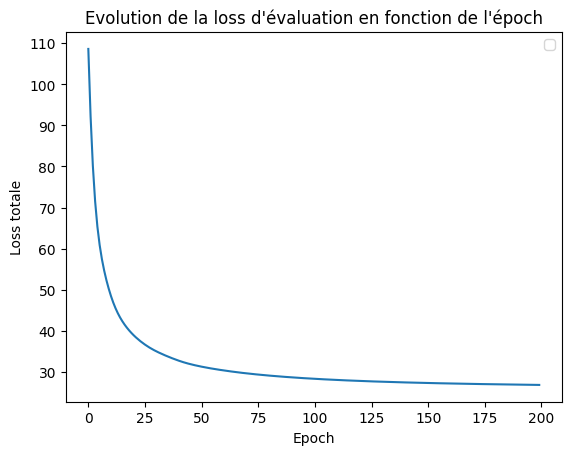

In [193]:
plt.xlabel("Epoch")
plt.ylabel("Loss totale")
plt.title("Evolution de la loss d'évaluation en fonction de l'époch")
plt.plot(np.arange(len(losses)), losses)
plt.legend()
plt.show()

Le modèle semble avoir atteint ses limites.
On a donc notre premier modèle baseline.

In [207]:
IPython.display.Audio(ancien, rate=8000) #with packet loss

In [208]:
IPython.display.Audio(x, rate=8000) #with packet loss

On constate une réelle différence, par exemple, le nom Verne semble être complété, de même pour le mot chapitre.

In [214]:
mse_score_parfait = MSE(y, y) #donne +inf : logique => métrique pas top pour ce genre de problèmes de paquet loss
mse_score_initial = MSE(y, ancien)
mse_score_reconstruction = MSE(y, x)
print("MSE témoin parfait", mse_score_parfait)
print("MSE avant reconstruction :", mse_score_initial)
print("MSE après reconstruction :", mse_score_reconstruction)

MSE témoin parfait 0.0
MSE avant reconstruction : 0.006237749481201172
MSE après reconstruction : 0.006348806381225586


In [204]:
snr_score_parfait = SNR(y, y) #donne +inf : logique => métrique pas top pour ce genre de problèmes de paquet loss
snr_score_initial = SNR(y, ancien)
snr_score_reconstruction = SNR(y, x)
print("SNR témoin parfait", snr_score_parfait)
print("SNR avant reconstruction :", snr_score_initial)
print("SNR après reconstruction :", snr_score_reconstruction)

SNR témoin parfait inf
SNR avant reconstruction : 3.323184336353639
SNR après reconstruction : 3.24654279739393


/tmp/ipykernel_614/845209022.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return 10*np.log10(L2_squared(x)/L2_squared(x-x_reconstructed))


In [206]:
stoi_score_parfait = stoi(y, y, samplerate)
stoi_score_initial = stoi(y, ancien, samplerate)
stoi_score_reconstruction = stoi(y, x, samplerate)
print("STOI témoin parfait :", stoi_score_parfait)
print("STOI avant reconstruction :", stoi_score_initial)
print("STOI après reconstruction :", stoi_score_reconstruction)

STOI témoin parfait : 0.9999999999999994
STOI avant reconstruction : 0.4984813465339311
STOI après reconstruction : 0.42114121665521026


Tous les scores ont été dégradés. 

In [250]:
score_model = score(dataset_eval)
print("Score model : ", score_model)
score_base = score(dataset_eval, with_model = False)
print("Score base: ", score_base)


100%|███████████████████████████████████████████████████████████████████████████████| 5295/5295 [00:56<00:00, 93.69it/s]


Score model :  0.0016559719869449355


100%|██████████████████████████████████████████████████████████████████████████████| 5295/5295 [00:44<00:00, 119.05it/s]

Score model :  0.001621347641087515


# Architectures sur le spectrogramme Seq2Seq ou U-Net

Nous avons un problème de type many-to-many qui se prête bien à l'utilisation d'un modèle Seq2Seq.

In [396]:
class Encoder(nn.Module):
    def __init__(self, input_size = 100, hidden_size = 128, num_layers = 1, bidirectional = False, dropout = 0.):
        super().__init__()
        self.rnn = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers,
                          bidirectional = bidirectional, dropout = dropout, batch_first = True).to(device)
        self.bidirectional = int(bidirectional) + 1
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
    def forward(self, batch):
        #batch
        output, hiddens = self.rnn(batch, )
        h = torch.cat((hiddens[-2,:,:], hiddens[-1,:,:]), dim=-1).unsqueeze(0) # Derniere layer, deux directions
        #c = torch.cat((cells[-2,:,:], cells[-1,:,:]), dim=-1).unsqueeze(0)
        #h, c = hiddens,cells
        return h
class Decoder(nn.Module):
    def __init__(self, input_size = 100, hidden_size = 256, output_dim = 100, num_layers = 2, dropout = 0.):
        super().__init__()
        
        self.rnn = nn.GRU(input_size = input_size, hidden_size = hidden_size , num_layers = num_layers,
                           dropout = dropout, batch_first = True, bidirectional = False).to(device)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.fc = nn.Linear(hidden_size , output_dim).to(device)
        
    def forward(self, batch, h):
        
        outputs, _ = self.rnn(batch, h)
        #outputs = outputs.squeeze(1)
        preds = self.fc(outputs)
        return preds
class Seq2Seq(nn.Module):
    def __init__(self,input_size = 100, hidden_size = 128, output_dim = 100):
        super().__init__()
        self.enc = Encoder(input_size = input_size, num_layers = 2, hidden_size = hidden_size, bidirectional = True)
        self.dec = Decoder(input_size = input_size, output_dim = input_size, hidden_size = hidden_size * 2, num_layers = 1,)
    def forward(self, batch):
        batch = batch.unsqueeze(1)
        h = self.enc(batch)
        output = self.dec(batch, h)
        return output.squeeze(1)

In [397]:
from torch.utils.data import DataLoader
batch_size = 32
train_loader= DataLoader(dataset_train, batch_size = batch_size, shuffle = True,)
test_loader= DataLoader(dataset_test, batch_size = batch_size)
val_loader= DataLoader(dataset_eval, batch_size = batch_size)

NameError: name 'dataset_test' is not defined

In [123]:
torch.backends.cudnn.benchmark = True
model_seq = Seq2Seq()
train(model_seq, )

  1%|▊                                                                                | 1/100 [01:36<2:38:54, 96.30s/it]

Loss eval :  73.76


 11%|████████▊                                                                       | 11/100 [15:00<1:59:57, 80.87s/it]

Loss eval :  35.28


 21%|████████████████▊                                                               | 21/100 [28:04<1:42:37, 77.95s/it]

Loss eval :  30.92


 31%|████████████████████████▊                                                       | 31/100 [40:52<1:28:10, 76.68s/it]

Loss eval :  28.89


 41%|████████████████████████████████▊                                               | 41/100 [53:58<1:18:08, 79.46s/it]

Loss eval :  27.91


 51%|███████████████████████████████████████▊                                      | 51/100 [1:07:32<1:07:06, 82.18s/it]

Loss eval :  27.23


 61%|████████████████████████████████████████████████▊                               | 61/100 [1:20:32<50:15, 77.32s/it]

Loss eval :  26.82


 71%|████████████████████████████████████████████████████████▊                       | 71/100 [1:33:23<37:18, 77.19s/it]

Loss eval :  26.57


 81%|████████████████████████████████████████████████████████████████▊               | 81/100 [1:46:04<24:34, 77.59s/it]

Loss eval :  26.39


 91%|████████████████████████████████████████████████████████████████████████▊       | 91/100 [1:59:15<12:00, 80.09s/it]

Loss eval :  26.26


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [2:11:08<00:00, 78.68s/it]


[tensor(73.7617, device='cuda:0'),
 tensor(58.5108, device='cuda:0'),
 tensor(53.0297, device='cuda:0'),
 tensor(48.5499, device='cuda:0'),
 tensor(42.2348, device='cuda:0'),
 tensor(40.7393, device='cuda:0'),
 tensor(40.8605, device='cuda:0'),
 tensor(39.9172, device='cuda:0'),
 tensor(38.0186, device='cuda:0'),
 tensor(36.2967, device='cuda:0'),
 tensor(35.2834, device='cuda:0'),
 tensor(34.6173, device='cuda:0'),
 tensor(34.0463, device='cuda:0'),
 tensor(33.7122, device='cuda:0'),
 tensor(33.5941, device='cuda:0'),
 tensor(33.3965, device='cuda:0'),
 tensor(32.9083, device='cuda:0'),
 tensor(32.2116, device='cuda:0'),
 tensor(31.5665, device='cuda:0'),
 tensor(31.1521, device='cuda:0'),
 tensor(30.9172, device='cuda:0'),
 tensor(30.7000, device='cuda:0'),
 tensor(30.4357, device='cuda:0'),
 tensor(30.1813, device='cuda:0'),
 tensor(29.9827, device='cuda:0'),
 tensor(29.8014, device='cuda:0'),
 tensor(29.5839, device='cuda:0'),
 tensor(29.3452, device='cuda:0'),
 tensor(29.1439, dev

In [125]:
torch.save(model_seq.state_dict(), "Seq2seq.model")

In [137]:
model_seq = Seq2Seq()
model_seq.load_state_dict(torch.load("Seq2seq.model", weights_only=True))


<All keys matched successfully>

In [139]:
losses_new = train(model_seq, n_epochs = 300)

Processing with loss : tensor(32.5521, device='cuda:0'):   0%|                        | 1/300 [01:20<6:39:34, 80.18s/it]

Loss eval :  32.55


Processing with loss : tensor(26.6061, device='cuda:0'):   4%|▊                      | 11/300 [14:45<6:26:34, 80.26s/it]

Loss eval :  26.61


Processing with loss : tensor(26.1899, device='cuda:0'):   7%|█▌                     | 21/300 [28:14<6:16:30, 80.97s/it]

Loss eval :  26.19


Processing with loss : tensor(25.9655, device='cuda:0'):  10%|██▍                    | 31/300 [41:36<6:00:23, 80.38s/it]

Loss eval :  25.97


Processing with loss : tensor(25.8312, device='cuda:0'):  14%|███▏                   | 41/300 [55:01<5:52:31, 81.67s/it]

Loss eval :  25.83


Processing with loss : tensor(25.7382, device='cuda:0'):  17%|███▌                 | 51/300 [1:08:47<5:42:34, 82.55s/it]

Loss eval :  25.74


Processing with loss : tensor(25.6599, device='cuda:0'):  20%|████▎                | 61/300 [1:22:39<5:31:23, 83.19s/it]

Loss eval :  25.66


Processing with loss : tensor(25.5861, device='cuda:0'):  24%|████▉                | 71/300 [1:36:20<5:09:52, 81.19s/it]

Loss eval :  25.59


Processing with loss : tensor(25.5131, device='cuda:0'):  27%|█████▋               | 81/300 [1:50:00<4:56:50, 81.33s/it]

Loss eval :  25.51


Processing with loss : tensor(25.4337, device='cuda:0'):  30%|██████▎              | 91/300 [2:03:46<4:49:00, 82.97s/it]

Loss eval :  25.43


Processing with loss : tensor(25.5491, device='cuda:0'):  34%|██████▋             | 101/300 [2:17:32<4:31:57, 82.00s/it]

Loss eval :  25.55


Processing with loss : tensor(25.3437, device='cuda:0'):  37%|███████▍            | 111/300 [2:31:15<4:21:09, 82.91s/it]

Loss eval :  25.34


Processing with loss : tensor(25.2092, device='cuda:0'):  40%|████████            | 121/300 [2:44:57<4:05:51, 82.41s/it]

Loss eval :  25.21


Processing with loss : tensor(25.1261, device='cuda:0'):  44%|████████▋           | 131/300 [2:58:37<3:50:19, 81.77s/it]

Loss eval :  25.13


Processing with loss : tensor(25.0909, device='cuda:0'):  47%|█████████▍          | 141/300 [3:12:15<3:36:40, 81.76s/it]

Loss eval :  25.09


Processing with loss : tensor(24.9763, device='cuda:0'):  50%|██████████          | 151/300 [3:25:56<3:20:34, 80.77s/it]

Loss eval :  24.98


Processing with loss : tensor(24.9883, device='cuda:0'):  54%|██████████▋         | 161/300 [3:39:15<3:05:05, 79.89s/it]

Loss eval :  24.99


Processing with loss : tensor(24.8507, device='cuda:0'):  57%|███████████▍        | 171/300 [3:52:36<2:52:55, 80.43s/it]

Loss eval :  24.85


Processing with loss : tensor(24.7988, device='cuda:0'):  60%|████████████        | 181/300 [4:06:02<2:39:45, 80.55s/it]

Loss eval :  24.80


Processing with loss : tensor(24.7278, device='cuda:0'):  64%|████████████▋       | 191/300 [4:19:24<2:26:07, 80.44s/it]

Loss eval :  24.73


Processing with loss : tensor(24.8280, device='cuda:0'):  67%|█████████████▍      | 201/300 [4:32:45<2:12:03, 80.03s/it]

Loss eval :  24.83


Processing with loss : tensor(24.6830, device='cuda:0'):  70%|██████████████      | 211/300 [4:45:59<1:57:27, 79.18s/it]

Loss eval :  24.68


Processing with loss : tensor(24.5936, device='cuda:0'):  74%|██████████████▋     | 221/300 [4:59:18<1:45:36, 80.21s/it]

Loss eval :  24.59


Processing with loss : tensor(24.5399, device='cuda:0'):  77%|███████████████▍    | 231/300 [5:12:41<1:32:11, 80.17s/it]

Loss eval :  24.54


Processing with loss : tensor(24.4874, device='cuda:0'):  80%|████████████████    | 241/300 [5:26:03<1:18:41, 80.02s/it]

Loss eval :  24.49


Processing with loss : tensor(24.6114, device='cuda:0'):  84%|████████████████▋   | 251/300 [5:39:23<1:05:39, 80.40s/it]

Loss eval :  24.61


Processing with loss : tensor(24.4282, device='cuda:0'):  87%|███████████████████▏  | 261/300 [5:52:48<51:54, 79.87s/it]

Loss eval :  24.43


Processing with loss : tensor(24.3726, device='cuda:0'):  90%|███████████████████▊  | 271/300 [6:06:19<39:39, 82.06s/it]

Loss eval :  24.37


Processing with loss : tensor(24.3516, device='cuda:0'):  94%|████████████████████▌ | 281/300 [6:19:58<25:56, 81.95s/it]

Loss eval :  24.35


Processing with loss : tensor(24.3007, device='cuda:0'):  97%|█████████████████████▎| 291/300 [6:33:38<12:16, 81.86s/it]

Loss eval :  24.30


Processing with loss : tensor(24.3301, device='cuda:0'): 100%|██████████████████████| 300/300 [6:45:58<00:00, 81.19s/it]


## UNET
Nous avons mis au point un modèle UNET, et nous avons considéré plusieurs approches différentes:

* Prédire la magnitude du spectrogramme : cette méthode permet de prédire une meilleure magnitude, cependant, utiliser la phase de l'exemple d'entrée réduit drastiquement les performances.
* Prédire indépendemment la partie réelle et la partie imaginaire : cette méthode n'est pas viable, car le modèle ne semble pas pouvoir apprendre de motifs intéressants.
* Prédire la phase : on peut représenter la phase comme deux canaux avec d'un côté les cosinus de la phase et de l'autre les sinus de la phase.

In [826]:
def train_unet(model, lr = 0.005, n_epochs = 100, print_step = 10, type_loss = "L2", proportion = 1. ):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 20, 40, 60, 80], gamma=0.5)
    if type_loss.upper() == "L1":
        loss = torch.nn.L1Loss()
    else:
        loss = torch.nn.MSELoss()
    losses_eval = []
    losses_train = []
    pbar = tqdm(range(n_epochs))
    loss_memorized = 1000
    params_memorized = None
    index = -1
    
    try:
        for i in pbar:
    
    
            model.train()
            
            l = 0
            j = 0
            loss_train = 0
            
            for batch, phase, true_val, true_phase in train_loader:
                if j  >= proportion * len(train_loader):
                    break
                
                output = model(batch)
                #dif_target = true_val - batch
                #dif_output = true_val - output
                l = loss(output, true_val)
                j += 1
                l.backward()
                optimizer.step()
                loss_train += l.detach().item()
                optimizer.zero_grad()
            scheduler.step()
            losses_train.append(loss_train / len(dataset_train))
            model.eval()
            with torch.no_grad():
                l = 0
                for batch, _,  true_val, _ in val_loader:
                    output = model(batch)
                    l += loss(output, true_val)
    
                losses_eval.append(l.item() / len(dataset_eval))
                if i % print_step == 0:
                    print(f"Loss eval :  {losses_eval[-1]}")
                pbar.set_description("Processing with loss : " + str(losses_eval[-1]))
                if losses_eval[-1] < loss_memorized:
                    loss_memorized = losses_eval[-1]
                    params_memorized = unet.state_dict()
                    index = i
    except KeyboardInterrupt:
        print("Interruption")
    
    return losses_train, losses_eval, params_memorized, loss_memorized, index

In [657]:
transform = T.Spectrogram( n_fft=511, hop_length=313, power = None, )
dataset_train = DatasetVoice(nb_samples = 80000, transform = transform)


100%|█████████████████████████████████████████████████████████████████████████████| 2118/2118 [00:01<00:00, 1965.29it/s]


In [658]:
prop_eval = 0.1
dataset_eval, dataset_train = random_split(dataset_train, [prop_eval, 1 -prop_eval])

In [659]:
batch_size = 32
train_loader = DataLoader(dataset_train, batch_size = batch_size,)
val_loader = DataLoader(dataset_eval, batch_size = batch_size)

In [671]:
class UNet_interpolation_phase(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.enc1 = self.down_conv(3, 16)
        self.enc2 = self.down_conv(16, 32)
        self.enc3 = self.down_conv(32, 64)
        self.enc4 = self.down_conv(64, 128)
        self.pool = nn.MaxPool2d(2, 2,)
        self.up1 = self.up(256)
        self.up2 = self.up(128)
        self.up3 = self.up(64)
        self.up4 = self.up(32)
        self.dec1 = self.up_conv(256, 128)
        self.dec2 = self.up_conv(128, 64)
        self.dec3 = self.up_conv(64, 32)
        self.dec4 = self.up_conv(32, 16)
        self.out = nn.Conv2d(16, 3, kernel_size = 1)
        self.bottom1 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bottom2 = nn.Conv2d(256, 256, 3, padding = 1)
        self.tanh = nn.Tanh()
    def down_conv(self, in_channels, out_channels, kernel_size = 3):
        return nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
        )
    def up(self, in_channels):
        return nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size = 2, stride = 2)
    def up_conv(self, in_channels, out_channels, kernel_size = 3):
        return nn.Sequential(
                            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = 1, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            )
    def forward(self, batch):
        e1 = self.enc1(batch)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.bottom2(self.bottom1(self.pool(e4)))
        d1 = self.up1(e5)

        # batch x Cannals x height x width
        d1 = torch.cat([e4, d1], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)

        # batch x Cannals x height x width

        d2 = torch.cat([e3, d2,], dim = 1) 
        d2 = self.dec2(d2)

        d3 = self.up3(d2)

        d3 = torch.cat([e2, d3,], dim = 1) 
        d3 = self.dec3(d3)
        d4 = self.up4(d3)


        d4 = torch.cat([e1, d4,], dim = 1) 
        d4 = self.dec4(d4)
        out = self.out(d4)
        out = self.tanh(out)
        return out.squeeze(1) 

In [812]:
class UNet_interpolation3(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.enc1 = self.down_conv(1, 16)
        self.enc2 = self.down_conv(16, 32)
        self.enc3 = self.down_conv(32, 64)
        self.enc4 = self.down_conv(64, 128)
        self.pool = nn.MaxPool2d(2, 2,)
        self.up1 = self.up(256)
        self.up2 = self.up(128)
        self.up3 = self.up(64)
        self.up4 = self.up(32)
        self.dec1 = self.up_conv(256, 128)
        self.dec2 = self.up_conv(128, 64)
        self.dec3 = self.up_conv(64, 32)
        self.dec4 = self.up_conv(32, 16)
        self.out = nn.Conv2d(16, 1, kernel_size = 1)
        self.bottom1 = nn.Conv2d(128, 256, 3, padding = 1)
        self.bottom2 = nn.Conv2d(256, 256, 3, padding = 1)
        self.sigmoid = nn.Sigmoid()
    def down_conv(self, in_channels, out_channels, kernel_size = 3):
        return nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
        )
    def up(self, in_channels):
        return nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size = 2, stride = 2)
    def up_conv(self, in_channels, out_channels, kernel_size = 3):
        return nn.Sequential(
                            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = 1, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 1, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            )
    def forward(self, batch):
        batch = batch.unsqueeze(1)
        e1 = self.enc1(batch)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.bottom2(self.bottom1(self.pool(e4)))
        d1 = self.up1(e5)

        # batch x Cannals x height x width

        d1 = torch.cat([e4, d1], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)

        # batch x Cannals x height x width

        d2 = torch.cat([e3, d2,], dim = 1) 
        d2 = self.dec2(d2)

        d3 = self.up3(d2)

        d3 = torch.cat([e2, d3,], dim = 1) 
        d3 = self.dec3(d3)
        d4 = self.up4(d3)


        d4 = torch.cat([e1, d4,], dim = 1) 
        d4 = self.dec4(d4)
        out = self.out(d4)
        out = self.sigmoid(out)
        return out.squeeze(1) 

In [823]:
class UNet_interpolation5(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.enc1 = self.down_conv(1, 16)
        self.enc2 = self.down_conv(16, 32)
        self.enc3 = self.down_conv(32, 64)
        self.enc4 = self.down_conv(64, 128)
        self.pool = nn.MaxPool2d(2, 2,)
        self.up1 = self.up(256)
        self.up2 = self.up(128)
        self.up3 = self.up(64)
        self.up4 = self.up(32)
        self.dec1 = self.up_conv(256, 128)
        self.dec2 = self.up_conv(128, 64)
        self.dec3 = self.up_conv(64, 32)
        self.dec4 = self.up_conv(32, 16)
        self.out = nn.Conv2d(16, 1, kernel_size = 1)
        self.bottom1 = nn.Conv2d(128, 256, 5, padding = 2)
        self.bottom2 = nn.Conv2d(256, 256, 5, padding = 2)
        self.sigmoid = nn.Sigmoid()
    def down_conv(self, in_channels, out_channels, kernel_size = 5):
        return nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 2, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 2, dtype= torch.float),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
        )
    def up(self, in_channels):
        return nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size = 2, stride = 2)
    def up_conv(self, in_channels, out_channels, kernel_size = 5):
        return nn.Sequential(
                            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = 2, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size , padding = 2, dtype= torch.float),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            )
    def forward(self, batch):
        batch = batch.unsqueeze(1)
        e1 = self.enc1(batch)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.bottom2(self.bottom1(self.pool(e4)))
        d1 = self.up1(e5)

        # batch x Cannals x height x width
        d1 = torch.cat([e4, d1], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)

        # batch x Cannals x height x width

        d2 = torch.cat([e3, d2,], dim = 1) 
        d2 = self.dec2(d2)

        d3 = self.up3(d2)

        d3 = torch.cat([e2, d3,], dim = 1) 
        d3 = self.dec3(d3)
        d4 = self.up4(d3)


        d4 = torch.cat([e1, d4,], dim = 1) 
        d4 = self.dec4(d4)
        out = self.out(d4)
        out = self.sigmoid(out)
        return out.squeeze(1) 

In [827]:

unet = UNet_interpolation3().to(device)


In [828]:
torch.backends.cudnn.benchmark = True
losses_train, losses_eval, params_mem, loss_mem, index_mem = train_unet(unet, lr = 0.02, n_epochs = 250, type_loss = "L1", proportion = 0.2)

Processing with loss : 0.001209099478316757:   0%|▏                                   | 1/250 [01:03<4:25:14, 63.91s/it]

Loss eval :  0.001209099478316757


Processing with loss : 0.00010634675832851878:   4%|█▍                               | 11/250 [12:24<5:03:15, 76.13s/it]

Loss eval :  0.00010634675832851878


Processing with loss : 8.658521791111748e-05:   8%|██▊                               | 21/250 [25:39<4:52:19, 76.59s/it]

Loss eval :  8.658521791111748e-05


Processing with loss : 7.966941855144951e-05:  12%|████▏                             | 31/250 [38:18<4:37:44, 76.09s/it]

Loss eval :  7.966941855144951e-05


Processing with loss : 7.539468307821255e-05:  16%|█████▌                            | 41/250 [50:49<4:21:46, 75.15s/it]

Loss eval :  7.539468307821255e-05


Processing with loss : 7.345258117706146e-05:  20%|██████▌                         | 51/250 [1:03:26<4:10:48, 75.62s/it]

Loss eval :  7.345258117706146e-05


Processing with loss : 7.201596338934494e-05:  24%|███████▊                        | 61/250 [1:16:02<3:58:04, 75.58s/it]

Loss eval :  7.201596338934494e-05


Processing with loss : 7.184158202331021e-05:  28%|█████████                       | 71/250 [1:28:38<3:46:11, 75.82s/it]

Loss eval :  7.184158202331021e-05


Processing with loss : 7.075426291744664e-05:  32%|██████████▎                     | 81/250 [1:41:23<3:35:48, 76.62s/it]

Loss eval :  7.075426291744664e-05


Processing with loss : 7.018636261938878e-05:  36%|███████████▋                    | 91/250 [1:54:10<3:20:57, 75.83s/it]

Loss eval :  7.018636261938878e-05


Processing with loss : 6.979517199380218e-05:  40%|████████████▌                  | 101/250 [2:06:50<3:09:17, 76.23s/it]

Loss eval :  6.979517199380218e-05


Processing with loss : 6.946415271399156e-05:  44%|█████████████▊                 | 111/250 [2:19:32<2:56:44, 76.29s/it]

Loss eval :  6.946415271399156e-05


Processing with loss : 6.923276298450974e-05:  48%|███████████████                | 121/250 [2:32:09<2:43:02, 75.84s/it]

Loss eval :  6.923276298450974e-05


Processing with loss : 6.879554217997586e-05:  52%|████████████████▏              | 131/250 [2:44:53<2:31:35, 76.43s/it]

Loss eval :  6.879554217997586e-05


Processing with loss : 6.867241430676208e-05:  56%|█████████████████▍             | 141/250 [2:57:40<2:19:15, 76.66s/it]

Loss eval :  6.867241430676208e-05


Processing with loss : 6.822153117577984e-05:  60%|██████████████████▋            | 151/250 [3:10:17<2:04:58, 75.74s/it]

Loss eval :  6.822153117577984e-05


Processing with loss : 6.799355483139461e-05:  64%|███████████████████▉           | 161/250 [3:23:25<2:02:58, 82.91s/it]

Loss eval :  6.799355483139461e-05


Processing with loss : 6.764565752643459e-05:  68%|█████████████████████▏         | 171/250 [3:36:57<1:44:03, 79.03s/it]

Loss eval :  6.764565752643459e-05


Processing with loss : 6.742793890946316e-05:  72%|██████████████████████▍        | 181/250 [3:50:09<1:30:56, 79.08s/it]

Loss eval :  6.742793890946316e-05


Processing with loss : 6.722533671220519e-05:  76%|███████████████████████▋       | 191/250 [4:03:10<1:16:48, 78.11s/it]

Loss eval :  6.722533671220519e-05


Processing with loss : 6.689141803192642e-05:  80%|████████████████████████▉      | 201/250 [4:16:06<1:02:57, 77.08s/it]

Loss eval :  6.689141803192642e-05


Processing with loss : 6.672405233641841e-05:  84%|███████████████████████████▊     | 211/250 [4:29:01<50:21, 77.47s/it]

Loss eval :  6.672405233641841e-05


Processing with loss : 6.664429685838943e-05:  88%|█████████████████████████████▏   | 221/250 [4:41:54<37:27, 77.48s/it]

Loss eval :  6.664429685838943e-05


Processing with loss : 6.613855355612511e-05:  92%|██████████████████████████████▍  | 231/250 [4:54:44<24:08, 76.22s/it]

Loss eval :  6.613855355612511e-05


Processing with loss : 6.594300656667296e-05:  96%|███████████████████████████████▊ | 241/250 [5:07:35<11:33, 77.10s/it]

Loss eval :  6.594300656667296e-05


Processing with loss : 6.566736144277285e-05: 100%|█████████████████████████████████| 250/250 [5:19:08<00:00, 76.59s/it]


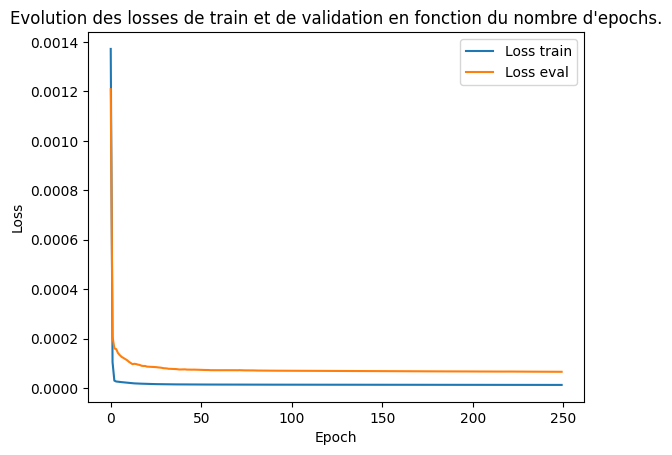

In [854]:
plt.plot(losses_train, label = "Loss train")
plt.plot(losses_eval, label = "Loss eval")
plt.title("Evolution des losses de train et de validation en fonction du nombre d'epochs.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [853]:
torch.save(unet.state_dict(), "Unet3.model")

In [893]:
dataset_test = DatasetVoice(nb_samples = 80000, type_ = "test", transform = transform)

100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:01<00:00, 658.78it/s]


Index choisi :  47


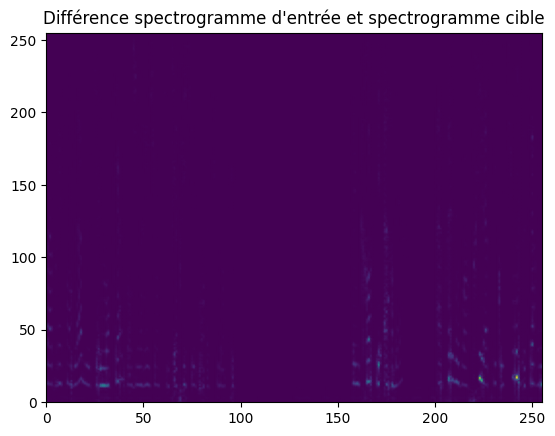

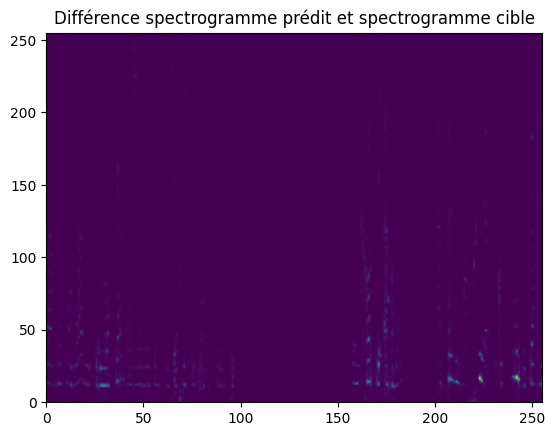

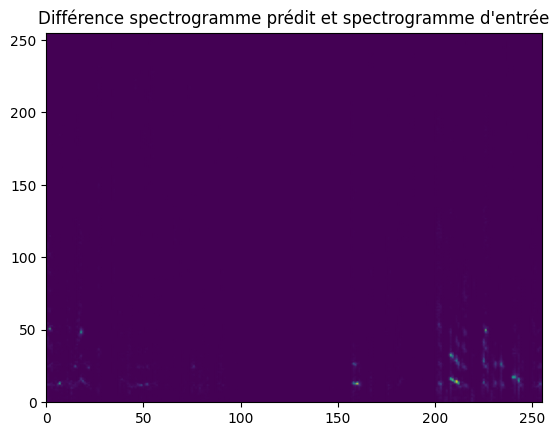

In [1024]:
dataset = dataset_eval
index = np.random.randint(len(dataset))
print("Index choisi : ", index)
pred = unet(dataset[index][0].unsqueeze(0)).squeeze(0)
plt.title("Différence spectrogramme d'entrée et spectrogramme cible")
plt.pcolormesh(np.arange(0, 256), np.arange(0, 256), np.abs( dataset[index][0].cpu().detach().numpy() - dataset[index][2].cpu().detach().numpy() ) , shading='gouraud', cmap='viridis')
plt.show()
plt.title("Différence spectrogramme prédit et spectrogramme cible")
plt.pcolormesh(np.arange(0, 256), np.arange(0, 256), np.abs( dataset[index][2].cpu().detach().numpy() - pred.cpu().detach().numpy() ) , shading='gouraud', cmap='viridis')
plt.show()
plt.title("Différence spectrogramme prédit et spectrogramme d'entrée")
plt.pcolormesh(np.arange(0, 256), np.arange(0, 256), np.abs( dataset[index][0].cpu().detach().numpy() - pred.cpu().detach().numpy() ) , shading='gouraud', cmap='viridis')
plt.show()
phase = dataset[index][1]
amp = pred
full = torch.polar(amp.cpu().detach(), phase.cpu().detach())
signal = T.InverseSpectrogram(n_fft = 511, hop_length = 313)(full).cpu().detach().numpy()
full_original = torch.polar(dataset[index][2].cpu().detach(), dataset[index][3].cpu().detach())
full_lost = torch.polar(dataset[index][0].cpu().detach(), dataset[index][1].cpu().detach())
original_signal = T.InverseSpectrogram(n_fft = 511, hop_length = 313)(full_original).cpu().detach().numpy()
lost_signal = T.InverseSpectrogram(n_fft = 511, hop_length = 313)(full_lost).cpu().detach().numpy()



In [1025]:
audio1 = IPython.display.Audio(signal, rate = 8000)
audio2 = IPython.display.Audio(original_signal, rate = 8000)
audio3 = IPython.display.Audio(lost_signal, rate = 8000)
pesq_predit =pesq(8000, original_signal, signal, 'nb')
pesq_lost = pesq(8000, original_signal, lost_signal, 'nb')
pesq_origin = pesq(8000, original_signal, original_signal, 'nb')
stoi_predit = stoi(original_signal, signal, 8000)
stoi_lost = stoi(original_signal, lost_signal, 8000)
stoi_origin = stoi(original_signal, original_signal, 8000)
mse_predit = ((original_signal - signal) ** 2).sum()
mse_lost = ((original_signal - lost_signal) ** 2).sum()
mse_origin = 0
print(f"Audio prédit (PESQ =  {pesq_predit} | STOI = {stoi_predit} | MSE = {mse_predit:.4f} ) ")
IPython.display.display(audio1)
print(f"Audio cible (PESQ =  {pesq_origin} | STOI = {stoi_origin} | MSE = {mse_origin:.4f} ) ")
IPython.display.display(audio2)
print(f"Audio de base (PESQ =  {pesq_lost} | STOI = {stoi_lost} | MSE = {mse_lost:.4f} ) ")
IPython.display.display(audio3)

Audio prédit (PESQ =  1.3802109956741333 | STOI = 0.7556873661539721 | MSE = 0.0954 ) 


Audio cible (PESQ =  4.548638343811035 | STOI = 0.9999999999999964 | MSE = 0.0000 ) 


Audio de base (PESQ =  1.2511839866638184 | STOI = 0.7547107520069288 | MSE = 0.1004 ) 


In [1041]:
def score_unet(dataset_train, model = None, number_examples = None):
    scores_predict = {"MSE" : [] , "SNR" : [] , "PESQ" : []  , "STOI" : [] }
    scores_old = {"MSE" : [] , "SNR" : [] , "PESQ" : []  , "STOI" : [] }
    ist = T.InverseSpectrogram(n_fft = 511, hop_length = 313).to(device)
    train_loader = DataLoader(dataset, batch_size = batch_size)
    i = 0
    for x, phase_x,  y, phase_y in tqdm(dataset):
        if i == number_examples:
            break
        i += 1
        x_old = x
        x = model(x.unsqueeze(0)).squeeze(0)
        x = torch.polar(x, phase_x)
        y = torch.polar(y, phase_y)
        x = ist(x)
        y = ist(y)
        x, y = x.cpu().detach().numpy(), y.cpu().detach().numpy()
        mse_score = ((y - x) ** 2).sum() / len(x)
        pesq_score = pesq(8000, y, x, "nb")
        stoi_score = stoi(y, x, 8000)
        scores_predict["MSE"].append(mse_score)
        scores_predict["PESQ"].append(pesq_score)
        scores_predict["STOI"].append(stoi_score)
        x_old = torch.polar(x_old, phase_x)
        x_old = ist(x_old)
        x_old, y = x_old.cpu().detach().numpy(), y
        power_noise = ((y - x) ** 2).sum() / len(x)
        power_y = (y ** 2).sum() / len(y)
        snr_score = 10 * np.log10(power_y / mse_score)
        scores_predict["SNR"].append(snr_score)
        mse_score = ((y - x_old) ** 2).sum() / len(x_old)
        pesq_score = pesq(8000, y, x_old, "nb")
        stoi_score = stoi(y, x_old, 8000)
        scores_old["MSE"].append(mse_score)
        scores_old["PESQ"].append(pesq_score)
        scores_old["STOI"].append(stoi_score)

        power_noise = ((y - x_old) ** 2).sum() / len(x_old)
        snr_score = 10 * np.log10(power_y / mse_score)
        scores_old["SNR"].append(snr_score)
        
    return scores_predict, scores_old

On constate une nette amélioration au niveau de toutes les métriques utilisées.

Au niveau des spectrogrammes, on a l'impression que le spectrogramme prédit est plus différent du spectrogramme cible que le spectrogramme d'entrée. On pourrait penser que le modèle réduit les micro-différences invisibles à l'oeil nu entre le spectrogramme d'entrée et la cible ce qui contribue à produire un audio de meilleure qualité, mais qu'il a du mal à réduire les différences importantes.

### Analyse des performances

In [1045]:
scores = score_unet(dataset_test, model = unet, number_examples = 100)

 47%|██████████████████████████████████████▏                                          | 100/212 [01:28<01:39,  1.13it/s]


(array([ 1.,  0.,  0.,  1.,  0.,  1.,  6., 10., 57., 24.]),
 array([-0.08966981, -0.07947053, -0.06927125, -0.05907196, -0.04887268,
        -0.0386734 , -0.02847412, -0.01827483, -0.00807555,  0.00212373,
         0.01232301]),
 <BarContainer object of 10 artists>)

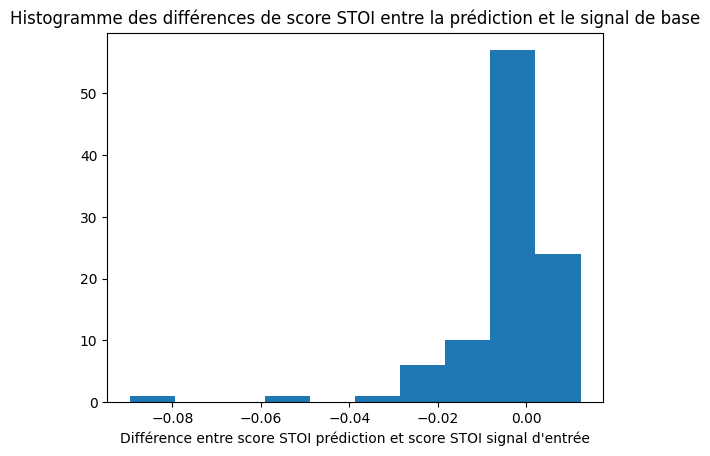

In [1037]:
plt.title("Histogramme des différences de score STOI entre la prédiction et le signal de base")
plt.xlabel("Différence entre score STOI prédiction et score STOI signal d'entrée")
plt.hist(np.array(scores[0]["STOI"]) - np.array(scores[1]["STOI"]) )

En considérant le score STOI, le modèle semble rendre l'audio légèrement moins compréhensible.

(array([ 1., 13., 18., 28., 17., 14.,  3.,  0.,  4.,  2.]),
 array([0.01282954, 0.04133028, 0.06983101, 0.09833175, 0.12683249,
        0.15533322, 0.18383396, 0.21233469, 0.24083543, 0.26933616,
        0.2978369 ]),
 <BarContainer object of 10 artists>)

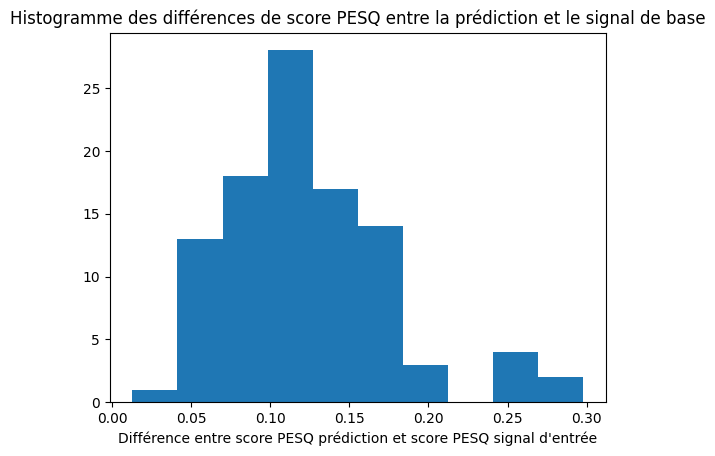

In [1036]:
plt.title("Histogramme des différences de score PESQ entre la prédiction et le signal de base")
plt.xlabel("Différence entre score PESQ prédiction et score PESQ signal d'entrée")
plt.hist(np.array(scores[0]["PESQ"]) - np.array(scores[1]["PESQ"]) )

Le score PESQ est amélioré dans tous les cas, mais l'amplitude de l'amélioration reste minime, et pratiquement indetectable à l'oreille.

(array([ 1.,  0.,  1.,  4.,  5., 19., 43., 18.,  6.,  3.]),
 array([-3.60546967, -3.12041989, -2.6353701 , -2.15032032, -1.66527053,
        -1.18022074, -0.69517096, -0.21012117,  0.27492861,  0.7599784 ,
         1.24502818]),
 <BarContainer object of 10 artists>)

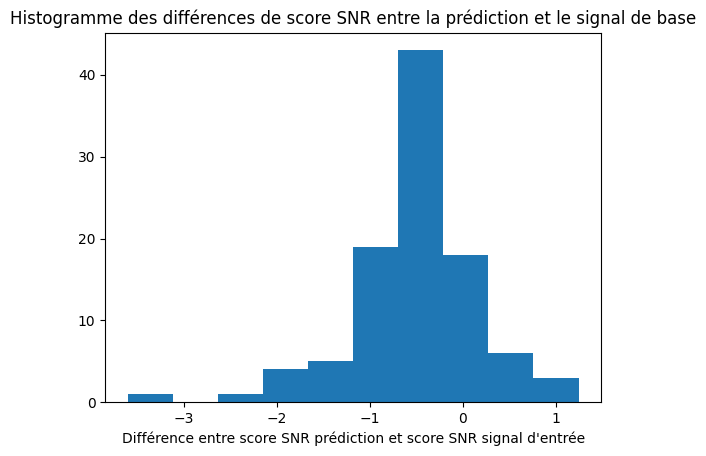

In [1035]:
plt.title("Histogramme des différences de score SNR entre la prédiction et le signal de base")
plt.xlabel("Différence entre score SNR prédiction et score SNR signal d'entrée")
plt.hist(np.array(scores[0]["SNR"]) - np.array(scores[1]["SNR"]) )

On aurait pû s'attendre à ce que le modèle rajoute du bruit, mais ce n'est pas le cas.

# Architectures sur la forme d'ondre Wave-U-Net

# Références
1. Kong, Qiuqiang & Cao, Yin & Liu, Haohe & Choi, Keunwoo & Wang, Yuxuan. (2021). Decoupling Magnitude and Phase Estimation with Deep ResUNet for Music Source Separation. 10.48550/arXiv.2109.05418.